<a href="https://colab.research.google.com/github/jnsbrdbr/hopefully_last_thesis/blob/main/1113_LogesticRegression1320.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

In [ ]:
#connect to google drive

from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load data

with pd.HDFStore('/content/drive/MyDrive/1000/part2_result',  mode='r') as newstore:
    result = newstore.select('result')


In [ ]:
#real has zero label and fake has one
#divide data in to data and label
#y is label

y=result.label
pd.options.mode.chained_assignment = None  # default='warn'
for i in range(len(y)):
  if y[i]==1:
    y[i]=0
  else:
    y[i]=1

In [ ]:
#X is data

result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel

In [ ]:
#The model

model = LogisticRegression(penalty='l2', C=0.1,solver='newton-cg',max_iter=1000)#

In [ ]:
#SMOTE

sm = SMOTE(sampling_strategy=1,k_neighbors=10)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

In [ ]:
#FPR

from sklearn.metrics import confusion_matrix


kf = KFold(n_splits=10,shuffle=True)#, random_state=None
res_fpr = list()
res_probas_=list()
Y_test_lst=list()
pred_values_lst=list()

for train_index , test_index in kf.split(X_train_oversampled,y_train_oversampled):
    i=0
    X_train , X_test = X_train_oversampled.iloc[train_index,:],X_train_oversampled.iloc[test_index,:]
    Y_train , Y_test = y_train_oversampled[train_index] , y_train_oversampled[test_index]

    final_model=model.fit(X_train,Y_train) #training model
    
    probas_ = final_model.predict_proba(X_test)#prediction based on probabilities    
    Y_test_lst.append(Y_test)
    res_probas_.append(probas_)
    
    res_probas_[i][:, [0, 1]] = res_probas_[i][:, [1, 0]]#swapping columns 0f 0,1

    pred_values = final_model.predict(X_test)
    pred_values_lst.append(pred_values)
    tn, fp, fn, tp = confusion_matrix(Y_test, pred_values, labels=[0, 1]).ravel()
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    fpr=(np.divide(fp,(fp+tn)))
    if fp==0:
      fpr=0

    y_test_arr=np.array(Y_test)
    count=0
    con=0
    for i in range(0,len(y_test_arr)):
       if y_test_arr[i]==1:
          count+=1
       else:
         con+=1
    print("number of fake:",count)
    print("number of real:",con)

    print('fpr=%.3f' % (mean(fpr)))#tpr=%.4f : mean(tpr), 
    res_fpr.append(mean(fpr))
    print('---------------------')
    i+=1


print('\n\n','total_fpr=%.3f' % mean(res_fpr))# total_tpr=%.4f :total_tpr,


True Positives: 26
False Positives: 1
True Negatives: 102
False Negatives: 3
number of fake: 29
number of real: 103
fpr=0.010
---------------------
True Positives: 26
False Positives: 0
True Negatives: 104
False Negatives: 2
number of fake: 28
number of real: 104
fpr=0.000
---------------------
True Positives: 35
False Positives: 1
True Negatives: 93
False Negatives: 3
number of fake: 38
number of real: 94
fpr=0.011
---------------------
True Positives: 30
False Positives: 0
True Negatives: 98
False Negatives: 4
number of fake: 34
number of real: 98
fpr=0.000
---------------------
True Positives: 30
False Positives: 1
True Negatives: 98
False Negatives: 3
number of fake: 33
number of real: 99
fpr=0.010
---------------------
True Positives: 27
False Positives: 2
True Negatives: 103
False Negatives: 0
number of fake: 27
number of real: 105
fpr=0.019
---------------------
True Positives: 30
False Positives: 1
True Negatives: 101
False Negatives: 0
number of fake: 30
number of real: 102
fp

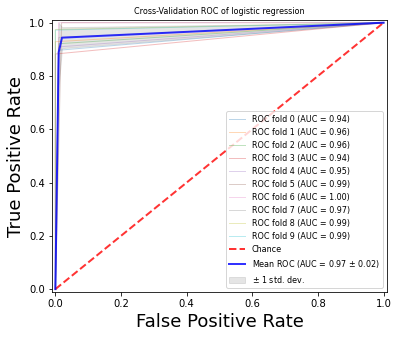

In [ ]:
#ROC_AUC


kf = KFold(n_splits=10,shuffle=True)
tprs = []
aucs = []
fpr_lst=list()
tpr_lst=list()
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(6,5))
i = 0
for _ , _ in kf.split(X,y):
    # Compute ROC curve and area the curve
    #fpr, tpr, thresholds = roc_curve(Y_test_lst[i],res_probas_[i][:,1] )
    fpr, tpr, thresholds = roc_curve(Y_test_lst[i],pred_values_lst[i])
    fpr_lst.append(mean(fpr))
    tpr_lst.append(mean(tpr))
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of logistic regression',fontsize=8)
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

In [ ]:
#recall/TPR

cv = KFold(n_splits=10, shuffle=True)#, shuffle=True, random_state=42
scores_recall = cross_val_score(model,X, y, scoring='recall', cv=cv)

print('scores_recall: %.3f (%.3f)' % (mean(scores_recall), std(scores_recall)))

scores_recall: 0.943 (0.050)


In [ ]:
#cross_validation and accracy

cv = KFold(n_splits=10, shuffle=True)#, random_state=42
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.983 (0.006)


In [ ]:
#precision

cv = KFold(n_splits=10, shuffle=True)#, shuffle=True, random_state=42
scores_precision = cross_val_score(model, X, y, scoring='precision', cv=cv)

print('scores_precision: %.3f (%.3f)' % (mean(scores_precision), std(scores_precision)))

scores_precision: 0.977 (0.022)
